<a href="https://colab.research.google.com/github/acsamaro/emd-desafio-civitas/blob/master/emd_desafio_civitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook para análise exploratória

# Configs

In [1]:
!pip install google-cloud-bigquery geopandas folium geojson shapely

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='centering-badge-427915-q3')

In [3]:
import pandas as pd
import os
from datetime import datetime
import geopandas as gpd
import folium
import geojson
from shapely import wkb
from shapely.geometry import mapping, Point, Polygon
import json
from math import radians
from geopy.distance import geodesic
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

# funcoes

In [4]:
def show_map(df, buffer):
  start_time = datetime.now()
  print("Inicio execucao: " + str(start_time))
  gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.camera_longitude, df.camera_latitude), crs="EPSG:4326")
  buffer_radius = buffer / 111000  # Aproximadamente buffer metros em graus
  gdf['buffer'] = gdf.geometry.buffer(buffer_radius)
  unified_geometry = gdf['buffer'].unary_union
  geojson_geometry = json.loads(gpd.GeoSeries([unified_geometry]).to_json())
  centroid = unified_geometry.centroid
  m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13)
  folium.GeoJson(data=geojson_geometry).add_to(m)
  end_time = datetime.now()
  print(f"Tempo de execução: " + str(end_time - start_time))
  return m

# Infos sobre os dados

## Verificacao duplicidade e nulos

In [ ]:
query = """
SELECT COUNT(*) AS total_records
FROM `rj-cetrio.desafio.readings_2024_06`;
"""

query_job = client.query(query)
results = query_job.result()
total_records = results.to_dataframe()

total_records

,total_records
0,36358536


In [ ]:
query = """
SELECT
  COUNTIF(datahora IS NULL) AS datahora_nulls,
  COUNTIF(datahora_captura IS NULL) AS datahora_captura_nulls,
  COUNTIF(placa IS NULL) AS placa_nulls,
  COUNTIF(empresa IS NULL) AS empresa_nulls,
  COUNTIF(tipoveiculo IS NULL) AS tipoveiculo_nulls,
  COUNTIF(velocidade IS NULL) AS velocidade_nulls,
  COUNTIF(camera_numero IS NULL) AS camera_numero_nulls,
  COUNTIF(camera_latitude IS NULL) AS camera_latitude_nulls,
  COUNTIF(camera_longitude IS NULL) AS camera_longitude_nulls
FROM `rj-cetrio.desafio.readings_2024_06`;
"""

query_job = client.query(query)
results = query_job.result()
null_counts = results.to_dataframe()

null_counts

,datahora_nulls,datahora_captura_nulls,placa_nulls,empresa_nulls,tipoveiculo_nulls,velocidade_nulls,camera_numero_nulls,camera_latitude_nulls,camera_longitude_nulls
0,0,1816325,0,0,0,0,0,0,0


In [ ]:
query = """
SELECT *
FROM `rj-cetrio.desafio.readings_2024_06`
WHERE
  datahora IS NOT NULL AND
  datahora_captura IS NOT NULL AND
  placa IS NOT NULL AND
  empresa IS NOT NULL AND
  tipoveiculo IS NOT NULL AND
  velocidade IS NOT NULL AND
  camera_numero IS NOT NULL AND
  camera_latitude IS NOT NULL AND
  camera_longitude IS NOT NULL;
"""

query_job = client.query(query)
results = query_job.result()
df = results.to_dataframe()

In [ ]:
df.describe()

,velocidade,camera_latitude,camera_longitude
count,34542211.0,3.454221e+07,3.454221e+07
mean,37.006145,-2.275249e+01,-4.299986e+01
std,15.012223,2.014014e+00,3.869847e+00
min,0.0,-2.385972e+01,-4.369023e+01
25%,28.0,-2.297336e+01,-4.339692e+01
50%,36.0,-2.292373e+01,-4.333635e+01
75%,46.0,-2.288919e+01,-4.324159e+01
max,255.0,0.000000e+00,4.333422e+01


## Retirada de Outliers

In [71]:
query = """
SELECT DISTINCT
  TO_HEX(camera_numero) AS camera_numero,
  camera_latitude,
  camera_longitude
FROM `rj-cetrio.desafio.readings_2024_06`
WHERE
  camera_numero IS NOT NULL AND
  camera_latitude IS NOT NULL AND
  camera_longitude IS NOT NULL
"""

query_job = client.query(query)
results = query_job.result()
df = results.to_dataframe()
df

,camera_numero,camera_latitude,camera_longitude
0,00692a7274b159,-22.883354,-43.237033
1,016fd26ef0c187,-22.947674,-43.577055
2,07f170eae1e582,-23.014852,-43.406444
3,099775e852edc1,-22.940606,-43.367684
4,0a1c745867ef55,-22.821611,-43.228861
...,...,...,...
1416,4d492d4a0176be,-23.005000,-43.559444
1417,633879e66ee299,-22.949064,-43.372700
1418,aa4b5cdfae2df5,-22.906111,-43.684444
1419,d311efe7cd7310,-22.879034,-43.336949


In [73]:
show_map(df, 100000)

Inicio execucao: 2024-07-01 21:04:05.077134


<ipython-input-4-5f4b7a8ff24e>:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf.geometry.buffer(buffer_radius)


Tempo de execução: 0:00:00.304565


In [12]:
bounding_box = Polygon([
    (-43.795, -23.082),  # Sudoeste
    (-43.105, -23.082),  # Sudeste
    (-43.105, -22.738),  # Nordeste
    (-43.795, -22.738)   # Noroeste
])

def is_within_bounding_box(lat, lon, bounding_box):
    point = Point(lon, lat)
    return bounding_box.contains(point)

df['within_bounding_box'] = df.apply(lambda row: is_within_bounding_box(row['camera_latitude'], row['camera_longitude'], bounding_box), axis=1)
cameras = df[df['within_bounding_box']]

cameras.reset_index(drop=True, inplace=True)

len(cameras)

1405

In [76]:
show_map(cameras, 250)

Inicio execucao: 2024-07-01 21:05:18.205084


<ipython-input-4-5f4b7a8ff24e>:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf.geometry.buffer(buffer_radius)


Tempo de execução: 0:00:00.502920


In [ ]:
cameras

,camera_numero,camera_latitude,camera_longitude,within_bounding_box
0,0237e7e0cedfcb,-22.797167,-43.193340,True
1,02aef868158b4f,-22.864900,-43.247900,True
2,04bca6ff669333,-22.819972,-43.226944,True
3,0a3d144ef05ff1,-22.973194,-43.208056,True
4,0beada277cd83f,-22.850469,-43.395011,True
...,...,...,...,...
1400,fd61eb3d803839,-22.852252,-43.316240,True
1401,c814ff30a288f6,-23.000292,-43.366858,True
1402,dda570387076a8,-22.924122,-43.313641,True
1403,4d492d4a0176be,-23.005000,-43.559444,True


In [ ]:
start = datetime.now()
print("Início: ", start)

# Função para calcular distância geodésica entre duas coordenadas
def calculate_geodesic_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Lista para armazenar distâncias
distances = []

# Calcular a distância entre cada par de câmeras
for i, camera1 in cameras.iterrows():
    for j, camera2 in cameras.iterrows():
        if i < j:  # Evitar duplicação e auto-distância
            coord1 = (camera1['camera_latitude'], camera1['camera_longitude'])
            coord2 = (camera2['camera_latitude'], camera2['camera_longitude'])
            distance = calculate_geodesic_distance(coord1, coord2)
            distances.append({
                'camera1': camera1['camera_numero'],
                'camera2': camera2['camera_numero'],
                'distance_km': distance
            })

# Criar um DataFrame com as distâncias
distances_df = pd.DataFrame(distances)
distances_df.head()

end = datetime.now()
print("Tempo de execução: ", end - start)

,camera1,camera2,distance_km
0,0237e7e0cedfcb,02aef868158b4f,9.361011
1,0237e7e0cedfcb,04bca6ff669333,4.275554
2,0237e7e0cedfcb,0a3d144ef05ff1,19.552021
3,0237e7e0cedfcb,0beada277cd83f,21.527570
4,0237e7e0cedfcb,0d40a210e1b765,21.157723


# Dados Relevantes

In [15]:
start = datetime.now()
print("Início: ", start)

# Gerar a lista de câmeras únicas
unique_cameras_list = cameras['camera_numero'].unique().tolist()

# Transformar a lista de câmeras únicas em uma string formatada para SQL
unique_cameras_str = ", ".join([f"'{camera}'" for camera in unique_cameras_list])

query = f"""
SELECT DISTINCT
  TO_HEX(camera_numero) AS camera_numero,
  TO_HEX(placa) AS placa,
  TO_HEX(empresa) AS empresa,
  TO_HEX(tipoveiculo) AS tipoveiculo,
  camera_latitude,
  camera_longitude,
  datahora,
  datahora_captura,
  velocidade
FROM `rj-cetrio.desafio.readings_2024_06`
WHERE
  datahora IS NOT NULL AND
  datahora_captura IS NOT NULL AND
  placa IS NOT NULL AND
  empresa IS NOT NULL AND
  tipoveiculo IS NOT NULL AND
  velocidade IS NOT NULL AND
  camera_numero IS NOT NULL AND
  camera_latitude IS NOT NULL AND
  camera_longitude IS NOT NULL AND
  TO_HEX(camera_numero) IN ({unique_cameras_str})
ORDER BY placa, datahora;
"""

query_job = client.query(query)
results = query_job.result()
df = results.to_dataframe()

end = datetime.now()
print("Tempo de execução: ", end - start)

df.head()

Início:  2024-07-01 17:08:16.383240
Tempo de execução:  0:00:59.847719


,camera_numero,placa,empresa,tipoveiculo,camera_latitude,camera_longitude,datahora,datahora_captura,velocidade
0,db279bab54b3f2,0000000d52acdf45d3b2f55e1f70c7e74d,1e2545af9d48c6,e2e0029fc0d3e5,-23.004099,-43.322689,2024-06-07 09:20:59+00:00,2024-06-07 09:22:02+00:00,28
1,17fb8f31a11844,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.862674,-43.247899,2024-06-08 13:32:39+00:00,2024-06-08 13:33:01+00:00,60
2,fcb8dbb8d6a743,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.843854,-43.250147,2024-06-08 13:34:49+00:00,2024-06-08 13:35:01+00:00,63
3,eb836e4b3ac6ff,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.904918,-43.266716,2024-06-08 15:52:17+00:00,2024-06-08 15:53:01+00:00,33
4,3a9ac4e7b4403c,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.916944,-43.260000,2024-06-08 17:57:16+00:00,2024-06-08 17:58:01+00:00,41


In [16]:
df.describe()

,camera_latitude,camera_longitude,velocidade
count,3.400016e+07,3.400016e+07,34000160.0
mean,-2.292896e+01,-4.334220e+01,36.979497
std,5.555054e-02,1.168262e-01,15.029913
min,-2.302947e+01,-4.369023e+01,0.0
25%,-2.297333e+01,-4.339739e+01,28.0
50%,-2.292452e+01,-4.333894e+01,36.0
75%,-2.289010e+01,-4.324383e+01,46.0
max,-2.279452e+01,-4.317139e+01,255.0



## Frequencia das Placas

In [17]:
# Contar as ocorrências de cada placa
placa_counts = df['placa'].value_counts()

# Contar o número de placas que aparecem apenas uma vez
num_placas_unicas = len(placa_counts[placa_counts == 1])

print(f"Número de placas que aparecem apenas uma vez: {num_placas_unicas}")


Número de placas que aparecem apenas uma vez: 4577181


In [18]:
placas_multiplas = placa_counts[placa_counts > 1].index

# Filtrar o DataFrame original para remover as placas únicas
df = df[df['placa'].isin(placas_multiplas)]

# Mostrar o DataFrame resultante
df.head()

,camera_numero,placa,empresa,tipoveiculo,camera_latitude,camera_longitude,datahora,datahora_captura,velocidade
1,17fb8f31a11844,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.862674,-43.247899,2024-06-08 13:32:39+00:00,2024-06-08 13:33:01+00:00,60
2,fcb8dbb8d6a743,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.843854,-43.250147,2024-06-08 13:34:49+00:00,2024-06-08 13:35:01+00:00,63
3,eb836e4b3ac6ff,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.904918,-43.266716,2024-06-08 15:52:17+00:00,2024-06-08 15:53:01+00:00,33
4,3a9ac4e7b4403c,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.916944,-43.260000,2024-06-08 17:57:16+00:00,2024-06-08 17:58:01+00:00,41
5,d8cb23594079f8,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.887337,-43.224028,2024-06-13 13:57:05+00:00,2024-06-13 13:58:01+00:00,18


## análise placas com tipos de veiculos diferentes

In [62]:
query = """
WITH
-- Filtra dados válidos
filtered_valid_data AS (
  SELECT DISTINCT
    TO_HEX(camera_numero) AS camera_numero,
    TO_HEX(placa) AS placa,
    TO_HEX(empresa) AS empresa,
    TO_HEX(tipoveiculo) AS tipoveiculo,
    camera_latitude,
    camera_longitude,
    datahora,
    datahora_captura,
    velocidade
  FROM
    `rj-cetrio.desafio.readings_2024_06`
  WHERE
    datahora IS NOT NULL
    AND datahora_captura IS NOT NULL
    AND placa IS NOT NULL
    AND empresa IS NOT NULL
    AND tipoveiculo IS NOT NULL
    AND velocidade IS NOT NULL
    AND camera_numero IS NOT NULL
    AND camera_latitude IS NOT NULL
    AND camera_longitude IS NOT NULL
    AND velocidade <> 0
    AND NOT (velocidade > 140 AND EXTRACT(HOUR FROM datahora) BETWEEN 6 AND 22)
    AND ST_WITHIN(
        ST_GEOGPOINT(camera_longitude, camera_latitude),
        ST_GEOGFROMTEXT('POLYGON((-43.795 -23.082, -43.105 -23.082, -43.105 -22.738, -43.795 -22.738, -43.795 -23.082))')
    )
),

-- Filtra placas que aparecem mais de uma vez
filtered_plates AS (
  SELECT
    placa
  FROM
    filtered_valid_data
  GROUP BY
    placa
  HAVING
    COUNT(*) > 1
),

-- Filtra dados válidos com placas que aparecem mais de uma vez
valid_data_with_multiple_plates AS (
  SELECT
    *
  FROM
    filtered_valid_data
  WHERE
    placa IN (SELECT placa FROM filtered_plates)
),

-- Identifica placas com múltiplos tipos de veículos
multiple_vehicle_types AS (
  SELECT
    placa,
    COUNT(DISTINCT tipoveiculo) AS vehicle_type_count
  FROM
    valid_data_with_multiple_plates
  GROUP BY
    placa
  HAVING
    vehicle_type_count > 1
)

SELECT
  placa,
  vehicle_type_count
FROM
  multiple_vehicle_types
ORDER BY
  placa;
"""
query_job = client.query(query)
results = query_job.result()
result = results.to_dataframe()


In [66]:
len(result['placa'].unique())

427574

In [45]:
vehicle_type_counts = df.groupby('placa')['tipoveiculo'].nunique().reset_index()
vehicle_type_counts.columns = ['placa', 'vehicle_type_count']

suspicious_plates_by_vehicle_type = vehicle_type_counts[vehicle_type_counts['vehicle_type_count'] > 1]
suspicious_plates_by_vehicle_type.head()

,placa,vehicle_type_count
25,00008c1f16d0af418ec9d8c47267bccff8,2
39,0000d423101a94f87dd84870a087d8b150,3
45,0000f1cd32ce38df1b8a1b68d41a7321c9,3
48,00010970ec4aa0ea43516295b124ac44a1,2
52,00011418db7ec00012e952e86d1121a0d4,2


In [46]:
df['suspicious'] = df['placa'].isin(suspicious_plates_by_vehicle_type['placa'])
df.head()

,camera_numero,placa,empresa,tipoveiculo,camera_latitude,camera_longitude,datahora,datahora_captura,velocidade,suspicious,...,next_datahora,time_diff,mean_agg,std_agg,mean_agg,std_agg,mean_agg,std_agg,mean_agg,std_agg
0,17fb8f31a11844,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.862674,-43.247899,2024-06-08 13:32:39+00:00,2024-06-08 13:33:01+00:00,60,False,...,2024-06-08 13:34:49+00:00,0 days 00:02:10,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751
1,fcb8dbb8d6a743,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.843854,-43.250147,2024-06-08 13:34:49+00:00,2024-06-08 13:35:01+00:00,63,False,...,2024-06-08 15:52:17+00:00,0 days 02:17:28,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751
2,eb836e4b3ac6ff,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.904918,-43.266716,2024-06-08 15:52:17+00:00,2024-06-08 15:53:01+00:00,33,False,...,2024-06-08 17:57:16+00:00,0 days 02:04:59,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751
3,3a9ac4e7b4403c,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.916944,-43.260000,2024-06-08 17:57:16+00:00,2024-06-08 17:58:01+00:00,41,False,...,2024-06-13 13:57:05+00:00,4 days 19:59:49,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751
4,d8cb23594079f8,00000025bf4ddc5682d684559331e18aae,1e2545af9d48c6,e2e0029fc0d3e5,-22.887337,-43.224028,2024-06-13 13:57:05+00:00,2024-06-13 13:58:01+00:00,18,False,...,2024-06-10 03:08:25+00:00,-4 days +13:11:20,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751,38.517385,16.462751


In [21]:
df[df['suspicious']==True].describe()

,camera_latitude,camera_longitude,velocidade
count,1.013070e+07,1.013070e+07,10130705.0
mean,-2.292474e+01,-4.330804e+01,35.44415
std,5.325412e-02,1.163420e-01,13.987263
min,-2.302947e+01,-4.369023e+01,0.0
25%,-2.297282e+01,-4.337272e+01,27.0
50%,-2.292350e+01,-4.326777e+01,35.0
75%,-2.288758e+01,-4.321790e+01,43.0
max,-2.279452e+01,-4.317139e+01,255.0


In [49]:
len(df[df['suspicious']==True]), len(df[df['suspicious']==True]['placa'].unique() )

(10130705, 428598)

## Análise das velocidades

Muitos dados com registro de velocidade de 0 km/h, esses dados serão desconsiderados por serem considerados outliers.

Dados com velocidade acima de 140 km/h entre o horario 6-22h também serao considerados outliers, visto que essa nao é uma velocidade normalmente alcancada dentro da cidade.

Registros com Velocidade Igual a Zero: 306884
Estatísticas Descritivas por Empresa:
                     count       mean        std  min   25%   50%   75%    max
empresa                                                                       
0891967b413fa4   8434752.0  34.297266   8.526059  1.0  29.0  34.0  39.0  160.0
1e2545af9d48c6  18195136.0  38.517385  16.462751  0.0  27.0  38.0  50.0  255.0
2ce01a80c7f3d0   2793091.0  31.697664  14.338566  1.0  22.0  30.0  40.0  149.0
Outliers Identificados:
                          datahora  velocidade
5020     2024-06-07 12:52:08+00:00         236
5027     2024-06-08 19:58:58+00:00         254
5833     2024-06-08 20:41:40+00:00         220
19803    2024-06-09 16:08:18+00:00         146
23751    2024-06-08 16:56:06+00:00         203
...                            ...         ...
26384540 2024-06-06 22:29:28+00:00         136
26441267 2024-06-12 13:43:52+00:00         137
27225554 2024-06-10 00:07:36+00:00         139
28005280 2024-06-10 15:52:1

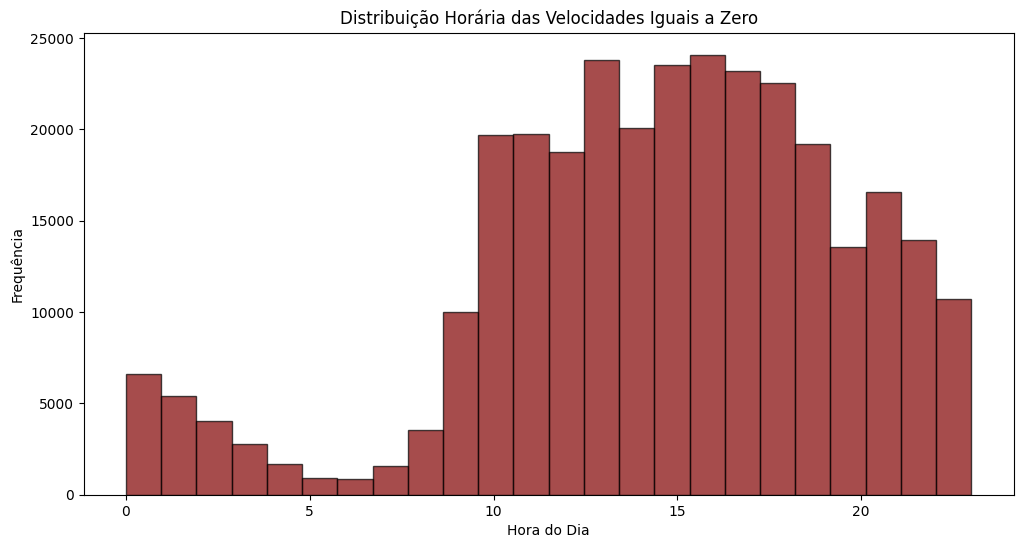

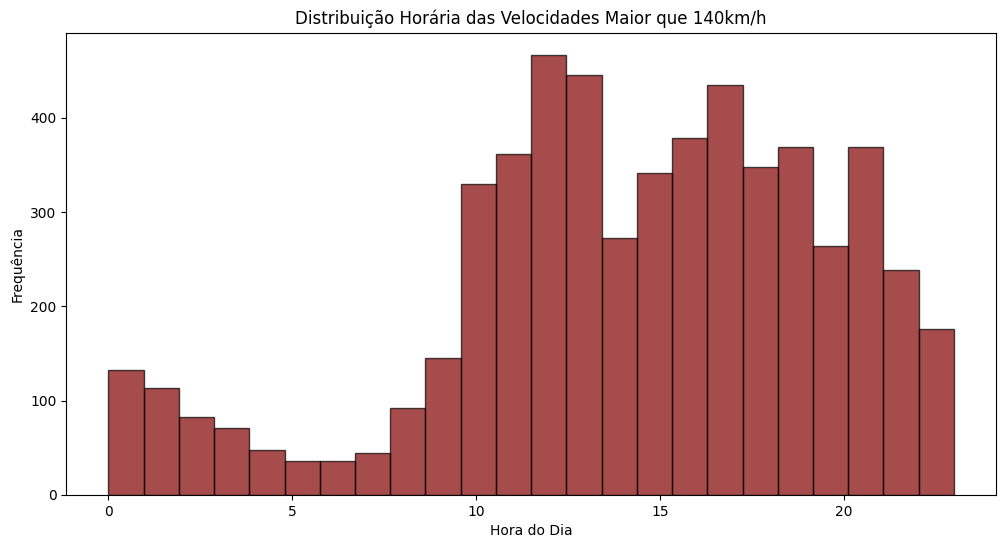

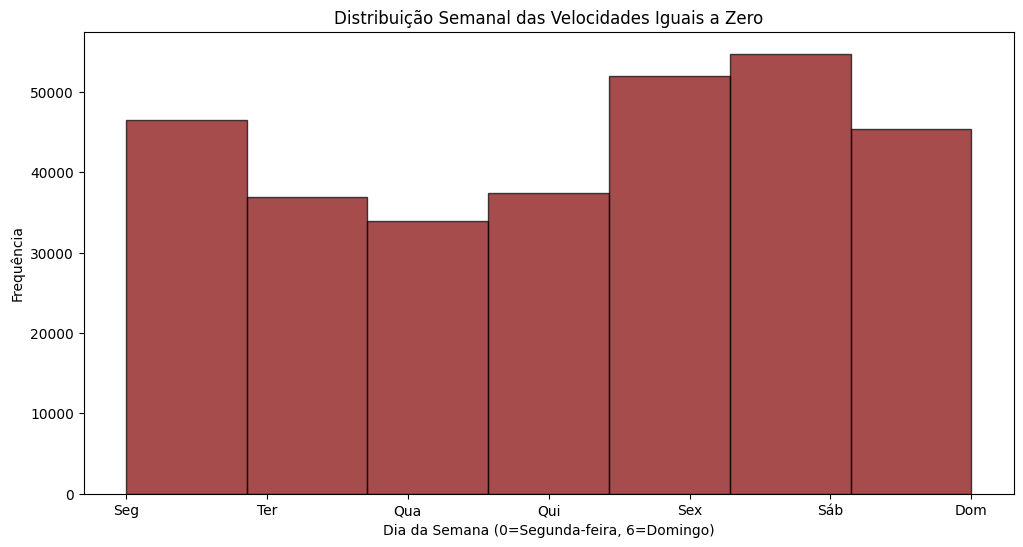

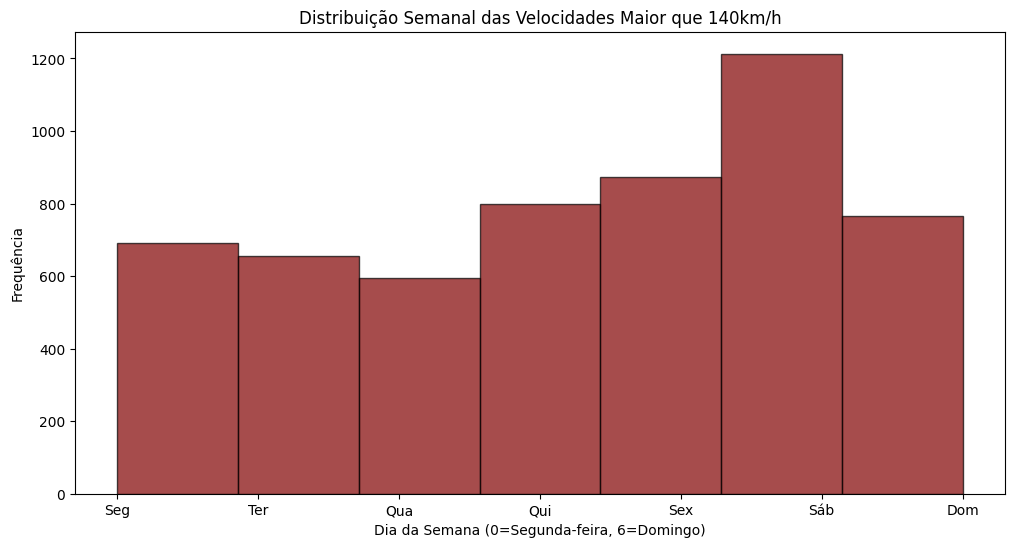

Registros com Velocidade Menor que 10 km/h:
                          datahora  velocidade
100      2024-06-09 12:39:24+00:00           0
110      2024-06-08 16:49:05+00:00           5
165      2024-06-09 21:45:25+00:00           0
183      2024-06-08 10:40:16+00:00           0
238      2024-06-06 16:28:53+00:00           7
...                            ...         ...
29416448 2024-06-07 11:12:32+00:00           8
29416692 2024-06-10 18:55:53+00:00           8
29418092 2024-06-10 13:17:55+00:00           9
29421376 2024-06-11 17:12:03+00:00           8
29422036 2024-06-09 10:52:47+00:00           9

[746592 rows x 2 columns]


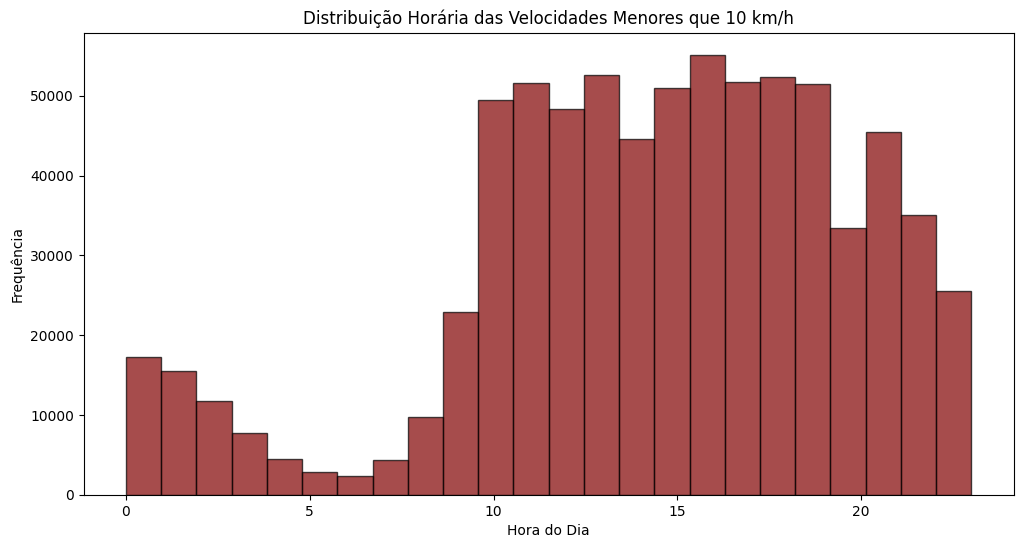

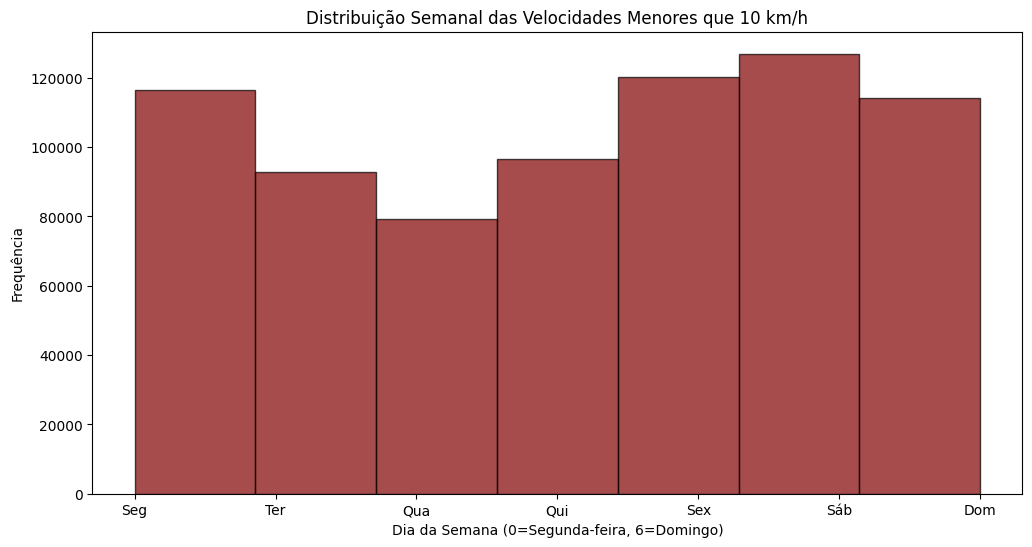

In [38]:
velocidade_zero = df[df['velocidade'] == 0]
print("Registros com Velocidade Igual a Zero:", len(velocidade_zero))

# Calcular estatísticas descritivas para cada empresa
company_stats = df.groupby('empresa')['velocidade'].describe()
print("Estatísticas Descritivas por Empresa:")
print(company_stats)

# Calcular a média e o desvio padrão para cada empresa
mean_std = df.groupby('empresa')['velocidade'].agg(['mean', 'std']).reset_index()

# Unir as estatísticas ao DataFrame original
df = pd.merge(df, mean_std, on='empresa', suffixes=('', '_agg'))

# Calcular o z-score manualmente para as velocidades
df['velocity_zscore'] = (df['velocidade'] - df['mean']) / df['std']

# Identificar outliers com base no z-score (por exemplo, z-score > 3 ou z-score < -3)
outliers = df[(df['velocidade'] > 135)]

print("Outliers Identificados:")
print(outliers[['datahora', 'velocidade']])

# Analisar os horários das medições de velocidade zero
velocidade_zero_hours = velocidade_zero['datahora'].dt.hour
plt.figure(figsize=(12, 6))
plt.hist(velocidade_zero_hours, bins=24, edgecolor='k', alpha=0.7, color='#800000')
plt.title('Distribuição Horária das Velocidades Iguais a Zero')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência')
plt.savefig('velocidade_zero_hora.pdf')
plt.show()


# Analisar os horários das medições de velocidades acima de 140km/h
outliers_hours = outliers['datahora'].dt.hour
plt.figure(figsize=(12, 6))
plt.hist(outliers_hours, bins=24, edgecolor='k', alpha=0.7, color='#800000')
plt.title('Distribuição Horária das Velocidades Maior que 140km/h')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência')
plt.savefig('velocidade_alta_hora.pdf')
plt.show()

# Analisar os dias da semana das medições de velocidade zero
velocidade_zero_days = velocidade_zero['datahora'].dt.dayofweek
plt.figure(figsize=(12, 6))
plt.hist(velocidade_zero_days, bins=7, edgecolor='k', alpha=0.7, align='mid', color='#800000')
plt.title('Distribuição Semanal das Velocidades Iguais a Zero')
plt.xlabel('Dia da Semana (0=Segunda-feira, 6=Domingo)')
plt.ylabel('Frequência')
plt.xticks(ticks=np.arange(7), labels=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])
plt.savefig('velocidade_zero_semana.pdf')
plt.show()


# Analisar os dias da semana das medições de velocidades maiores que 140
outliers_days = outliers['datahora'].dt.dayofweek
plt.figure(figsize=(12, 6))
plt.hist(outliers_days, bins=7, edgecolor='k', alpha=0.7, align='mid', color='#800000')
plt.title('Distribuição Semanal das Velocidades Maior que 140km/h')
plt.xlabel('Dia da Semana (0=Segunda-feira, 6=Domingo)')
plt.ylabel('Frequência')
plt.xticks(ticks=np.arange(7), labels=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])
plt.savefig('velocidade_alta_semana.pdf')
plt.show()


# Analisar os registros com velocidade menor que 10 km/h
velocidade_baixa = df[df['velocidade'] < 10]

print("Registros com Velocidade Menor que 10 km/h:")
print(velocidade_baixa[['datahora', 'velocidade']])

# Analisar os horários das medições de velocidade baixa (menor que 10 km/h)
velocidade_baixa_hours = velocidade_baixa['datahora'].dt.hour
plt.figure(figsize=(12, 6))
plt.hist(velocidade_baixa_hours, bins=24, edgecolor='k', alpha=0.7, color='#800000')
plt.title('Distribuição Horária das Velocidades Menores que 10 km/h')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência')
plt.savefig('velocidade_baixa_hora.pdf')
plt.show()


# Analisar os dias da semana das medições de velocidade baixa (menor que 10 km/h)
velocidade_baixa_days = velocidade_baixa['datahora'].dt.dayofweek
plt.figure(figsize=(12, 6))
plt.hist(velocidade_baixa_days, bins=7, edgecolor='k', alpha=0.7, align='mid', color='#800000')
plt.title('Distribuição Semanal das Velocidades Menores que 10 km/h')
plt.xlabel('Dia da Semana (0=Segunda-feira, 6=Domingo)')
plt.ylabel('Frequência')
plt.xticks(ticks=np.arange(7), labels=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])
plt.savefig('velocidade_baixa_semana.pdf')
plt.show()

In [23]:
# Filtrar velocidades muito altas entre 0h e 6h
outliers_velocidade_alta = df[(df['velocidade'] > 140) & (df['datahora'].dt.hour.between(6, 21))]

print(outliers_velocidade_alta[['datahora', 'placa', 'velocidade', 'camera_numero']], len(outliers_velocidade_alta))

                          datahora                               placa  \
5020     2024-06-07 12:52:08+00:00  001079b3579b24361772a25d9bb107b31a   
5027     2024-06-08 19:58:58+00:00  001079b3579b24361772a25d9bb107b31a   
5833     2024-06-08 20:41:40+00:00  0013f1af65145dbf565cb8d36e606f27e8   
19803    2024-06-09 16:08:18+00:00  004484497114a51d696ba226e87a130c33   
23751    2024-06-08 16:56:06+00:00  0052005f5fa851ed2f2bda6b111a69e247   
...                            ...                                 ...   
20981906 2024-06-07 19:04:51+00:00  ff6e6f39a3d5971036c62eadae65560414   
20985247 2024-06-12 10:40:17+00:00  ffb7f0adc270dfa0539e601448d4bfa04d   
21959545 2024-06-10 10:34:16+00:00  1d70b657731eb9418c5d95b8353d83d8d9   
23241361 2024-06-07 19:21:47+00:00  44507c238fa7aa0b5795d5e2732c2e434b   
25655776 2024-06-12 15:29:49+00:00  8d42f07f64b958ca7f84de9a715ac7143b   

          velocidade  
5020             236  
5027             254  
5833             220  
19803            14

In [37]:
outliers_velocidade_alta.groupby(['empresa']).size().reset_index(name='counts')

,empresa,counts
0,0891967b413fa4,3
1,1e2545af9d48c6,3649
2,2ce01a80c7f3d0,345


from matplotlib import pyplot as plt
_df_0['counts'].plot(kind='hist', bins=20, title='counts')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('empresa').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['counts'].plot(kind='line', figsize=(8, 4), title='counts')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['empresa'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='counts', y='empresa', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [24]:
suspeitos = df[(df['velocidade'] > 140) & (df['datahora'].dt.hour.between(0, 6))]
print("Suspeitos Identificados:")
suspeitos[['datahora', 'velocidade']]

Suspeitos Identificados:


,datahora,velocidade
86829,2024-06-11 05:04:03+00:00,142
176466,2024-06-07 06:14:26+00:00,150
182061,2024-06-10 02:13:51+00:00,219
271624,2024-06-10 00:29:27+00:00,186
427963,2024-06-07 00:58:05+00:00,233
...,...,...
20927390,2024-06-11 04:21:40+00:00,146
20928113,2024-06-11 04:22:25+00:00,149
20943671,2024-06-10 01:57:23+00:00,141
20955963,2024-06-12 00:03:02+00:00,144


In [25]:
len(suspeitos[suspeitos['suspicious'] == False])

242

Top 10 Câmeras com Maior Quantidade de Registros Suspeitos:
     camera_numero  count
23  35474aa1a885eb     96
64  98ed4fb8411a10     31
35  59e78abd8d6c76     25
74  af5c68c658e2d5     18
53  82871e4645d035     16
41  682e80767a8d2f     12
66  a6f22a3bf865b6     11
11  19848a74999f81     11
20  2b5b868ec12c9c     10
97  fa78635b813cee      7
52  81f40783ba5ed9      6
7   1373c01f694076      5
73  aee7414a785af6      4
40  66545bfa782b8f      4
31  475e6a596f6c3c      4
18  28026cd3c9d92b      4
42  69d7a9f973dd1c      3
29  42f91f4063dec9      3
91  e678ea910d0e7d      3
21  336eb912c978c2      3


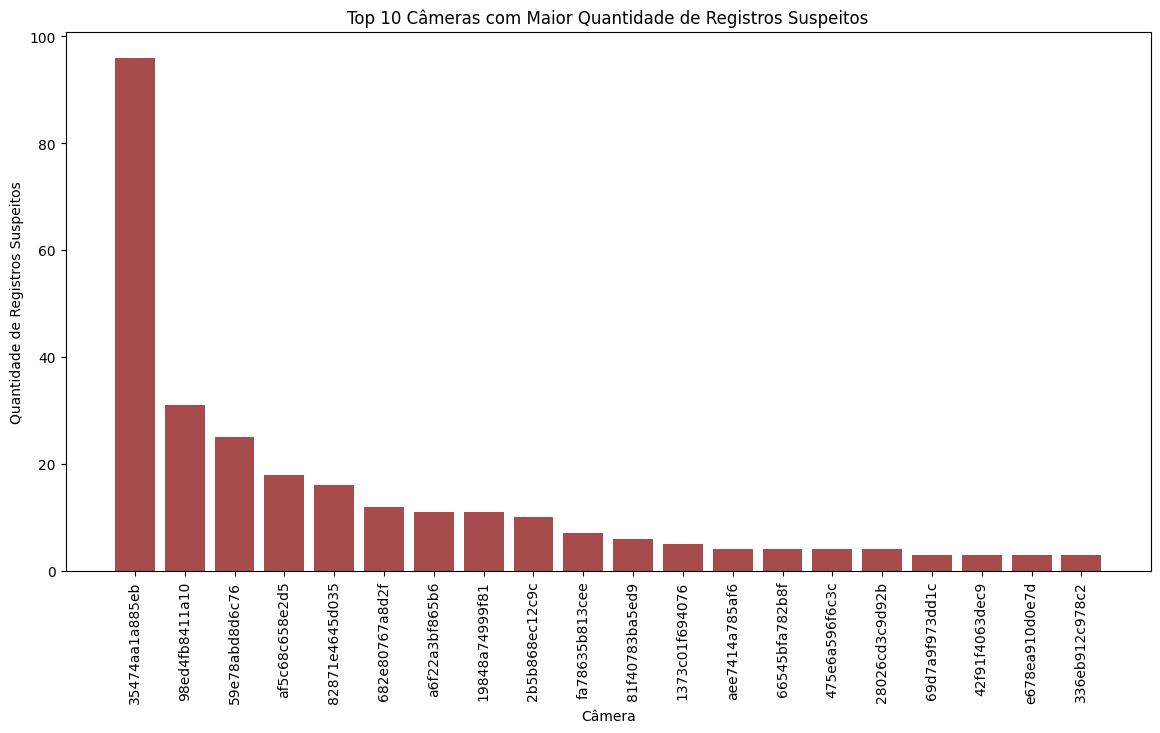

In [33]:
# Ordenar e selecionar os 10 maiores casos
top_10_cameras = suspeitos_por_camera.sort_values(by='count', ascending=False).head(20)

print("Top 10 Câmeras com Maior Quantidade de Registros Suspeitos:")
print(top_10_cameras)

# Visualizar os resultados
plt.figure(figsize=(14, 7))
plt.bar(top_10_cameras['camera_numero'], top_10_cameras['count'], alpha=0.7, color='#800000')
plt.title('Top 10 Câmeras com Maior Quantidade de Registros Suspeitos')
plt.xlabel('Câmera')
plt.ylabel('Quantidade de Registros Suspeitos')
plt.xticks(rotation=90)
plt.show()

In [30]:
show_map(top_10_cameras, 500)

Inicio execucao: 2024-07-01 17:12:04.418699
Tempo de execução: 0:00:00.045989


<ipython-input-4-5f4b7a8ff24e>:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf.geometry.buffer(buffer_radius)


# Query

In [101]:
query = """
WITH
-- Filtra dados válidos
filtered_valid_data AS (
  SELECT DISTINCT
    TO_HEX(camera_numero) AS camera_numero,
    TO_HEX(placa) AS placa,
    TO_HEX(empresa) AS empresa,
    TO_HEX(tipoveiculo) AS tipoveiculo,
    camera_latitude,
    camera_longitude,
    datahora,
    datahora_captura,
    velocidade
  FROM
    `rj-cetrio.desafio.readings_2024_06`
  WHERE
    datahora IS NOT NULL
    AND datahora_captura IS NOT NULL
    AND placa IS NOT NULL
    AND empresa IS NOT NULL
    AND tipoveiculo IS NOT NULL
    AND velocidade IS NOT NULL
    AND camera_numero IS NOT NULL
    AND camera_latitude IS NOT NULL
    AND camera_longitude IS NOT NULL
    AND velocidade > 0
    AND NOT (velocidade > 140 AND EXTRACT(HOUR FROM datahora) BETWEEN 6 AND 22)
    AND ST_WITHIN(
        ST_GEOGPOINT(camera_longitude, camera_latitude),
        ST_GEOGFROMTEXT('POLYGON((-43.795 -23.082, -43.105 -23.082, -43.105 -22.738, -43.795 -22.738, -43.795 -23.082))')
    )
),

-- Filtra placas que aparecem mais de uma vez
filtered_plates AS (
  SELECT
    placa
  FROM
    filtered_valid_data
  GROUP BY
    placa
  HAVING
    COUNT(*) > 1
),

-- Filtra dados válidos com placas que aparecem mais de uma vez
valid_data_with_multiple_plates AS (
  SELECT
    *
  FROM
    filtered_valid_data
  WHERE
    placa IN (SELECT placa FROM filtered_plates)
),

-- Calcula diferença de tempo entre registros consecutivos
base_time_diff_data AS (
  SELECT
    *,
    LEAD(datahora) OVER (PARTITION BY placa ORDER BY datahora) AS next_datahora,
    LEAD(camera_numero) OVER (PARTITION BY placa ORDER BY datahora) AS next_camera_numero,
    LEAD(camera_latitude) OVER (PARTITION BY placa ORDER BY datahora) AS next_latitude,
    LEAD(camera_longitude) OVER (PARTITION BY placa ORDER BY datahora) AS next_longitude,
    TIMESTAMP_DIFF(LEAD(datahora) OVER (PARTITION BY placa ORDER BY datahora), datahora, SECOND) AS time_diff
  FROM
    valid_data_with_multiple_plates
),

-- Calcula a distância geodésica entre pontos consecutivos
geo_distance_calculation AS (
  SELECT
    *,
    ST_DISTANCE(
      ST_GEOGPOINT(camera_longitude, camera_latitude),
      ST_GEOGPOINT(next_longitude, next_latitude)
    ) / 1000 AS distance_km
  FROM
    base_time_diff_data
),

-- Calcula velocidade baseada na distância e tempo
velocity_calculation AS (
  SELECT
    *,
    CASE
      WHEN time_diff > 0 THEN distance_km / (time_diff / 3600)
      ELSE NULL
    END AS velocity_kmh
  FROM
    geo_distance_calculation
),

-- Identifica placas com múltiplos tipos de veículos
multiple_vehicle_types AS (
  SELECT
    placa,
    COUNT(DISTINCT tipoveiculo) AS vehicle_type_count
  FROM
    valid_data_with_multiple_plates
  GROUP BY
    placa
  HAVING
    vehicle_type_count > 1
),

-- Identifica possíveis placas clonadas
possible_clones AS (
  SELECT
    v.*,
    mv.placa IS NOT NULL AS multiple_vehicle_types
  FROM
    velocity_calculation v
  LEFT JOIN
    multiple_vehicle_types mv
  ON
    v.placa = mv.placa
  WHERE
    (v.velocity_kmh > 70  AND v.time_diff< 3600)
    OR mv.placa IS NOT NULL
)

SELECT
  *
FROM
  possible_clones
ORDER BY
  placa, datahora;

"""

query_job = client.query(query)
results = query_job.result()
result = results.to_dataframe()


In [97]:
len(result)

10281293

In [70]:
len(result['placa'].unique())

583885

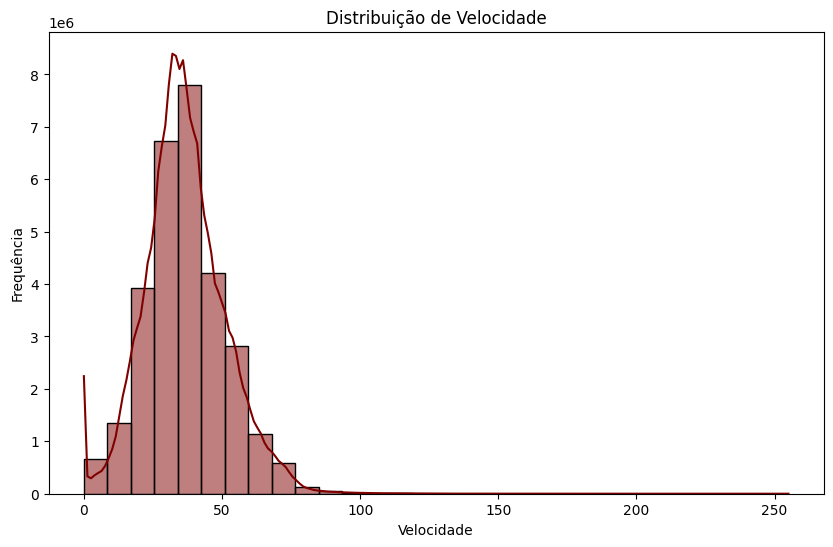

In [44]:
# Distribuição das velocidades
plt.figure(figsize=(10, 6))
sns.histplot(df['velocidade'], bins=30, kde=True, color='#800000')
plt.title('Distribuição de Velocidade')
plt.xlabel('Velocidade')
plt.ylabel('Frequência')
plt.savefig('velocidade_distribuicao.pdf')
plt.show()

In [77]:
result.describe()

,camera_latitude,camera_longitude,velocidade,next_latitude,next_longitude,time_diff,distance_km,velocity_kmh
count,1.028129e+07,1.028129e+07,10281293.0,9.853719e+06,9.853719e+06,9853719.0,9.853719e+06,9.797735e+06
mean,-2.292476e+01,-4.330951e+01,35.977298,-2.292501e+01,-4.330954e+01,17988.724844,4.888010e+00,3.232923e+01
std,5.301887e-02,1.169824e-01,13.662663,5.303558e-02,1.168182e-01,43246.524396,6.377956e+00,4.574659e+02
min,-2.302947e+01,-4.369023e+01,1.0,-2.302947e+01,-4.369023e+01,0.0,0.000000e+00,0.000000e+00
25%,-2.297083e+01,-4.337346e+01,28.0,-2.297282e+01,-4.337376e+01,247.0,8.119829e-01,7.189634e-01
50%,-2.292352e+01,-4.326874e+01,35.0,-2.292352e+01,-4.326874e+01,1565.0,2.307750e+00,7.911118e+00
75%,-2.288835e+01,-4.321856e+01,43.0,-2.288835e+01,-4.321856e+01,10691.0,6.413301e+00,2.803992e+01
max,-2.279452e+01,-4.317139e+01,248.0,-2.279452e+01,-4.317139e+01,646442.0,5.508689e+01,1.803274e+05


## Localizacao das cameras

       camera_numero  camera_latitude  camera_longitude  count
40    0a3d144ef05ff1       -22.973194        -43.208056  70541
924   b58d818d4f6a88       -22.973176        -43.208053  60231
1118  dd1b2e84d4655c       -22.933803        -43.182939  57985
494   637b2c86deca5f       -22.973176        -43.208053  54323
560   6f4203e0cec21a       -22.930639        -43.208942  51839
795   9a4b77841e00b7       -22.973194        -43.208056  49755
1293  fc54c03e76ae20       -22.900278        -43.279222  45391
1115  dc335d85e29a92       -22.978358        -43.225964  44438
850   a852c010348447       -22.935722        -43.244306  43327
181   23f55242442716       -22.929172        -43.231583  42753
403   506bbb84868706       -22.978358        -43.225964  42702
1082  d4cc9e68ef744f       -22.933803        -43.182939  38482
269   35474aa1a885eb       -22.958334        -43.197136  36313
1074  d3da3e4ffd41a4       -22.953333        -43.171389  34987
1084  d53f7499c95f72       -22.859400        -43.247700

<ipython-input-78-b3804c2f2024>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='camera_numero', data=top_cameras, palette='viridis')


Text(0, 0.5, 'Câmera')

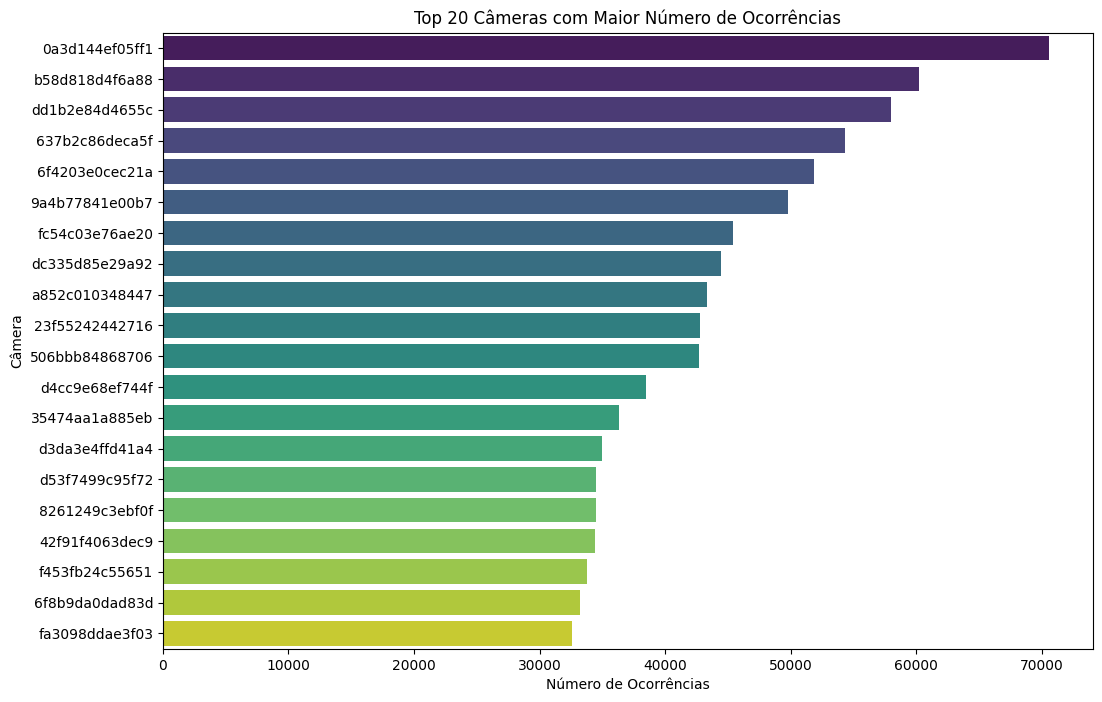

In [78]:
# Agrupar os dados por camera_numero, mantendo a latitude e longitude e contando as ocorrências
camera_counts = result.groupby(['camera_numero', 'camera_latitude', 'camera_longitude']).size().reset_index(name='count')

# Mostrar as câmeras com maior número de ocorrências
top_cameras = camera_counts.nlargest(20, 'count')
print(top_cameras)

# Plotar a distribuição das ocorrências por câmera (Top 10) com coordenadas
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='camera_numero', data=top_cameras, palette='viridis')
plt.title('Top 20 Câmeras com Maior Número de Ocorrências')
plt.xlabel('Número de Ocorrências')
plt.ylabel('Câmera')

In [ ]:
show_map(top_cameras, 500)

Verificar camera_numero diferentes com mesma coordenada

In [80]:
# Agrupar os dados por latitude e longitude e contar o número de câmeras em cada grupo
same_coords_count = cameras.groupby(['camera_latitude', 'camera_longitude']).agg({'camera_numero': 'nunique'}).reset_index()

# Filtrar grupos com mais de uma câmera
same_coords_count = same_coords_count[same_coords_count['camera_numero'] > 1]

# Renomear a coluna para 'count'
same_coords_count = same_coords_count.rename(columns={'camera_numero': 'count'})

# Mostrar o resultado
print(same_coords_count)

     camera_latitude  camera_longitude  count
0         -23.029469        -43.468891      2
1         -23.020833        -43.497500      4
2         -23.020833        -43.497222      2
3         -23.020278        -43.501111      2
4         -23.020106        -43.488411      3
..               ...               ...    ...
603       -22.814364        -43.295557      3
604       -22.809444        -43.226944      2
605       -22.807719        -43.207517      2
607       -22.797167        -43.193340      3
608       -22.794522        -43.172734      2

[532 rows x 3 columns]


In [81]:
# Criar um mapeamento das coordenadas duplicadas para uma única câmera
# Para simplicidade, escolheremos a primeira câmera de cada coordenada duplicada
coord_to_camera_map = {}
for index, row in same_coords_count.iterrows():
    coord_key = (row['camera_latitude'], row['camera_longitude'])
    first_camera = result[(result['camera_latitude'] == row['camera_latitude']) &
                           (result['camera_longitude'] == row['camera_longitude'])]['camera_numero'].iloc[0]
    coord_to_camera_map[coord_key] = first_camera

# Aplicar o mapeamento para atualizar o nome da câmera
def update_camera_numero(row):
    coord_key = (row['camera_latitude'], row['camera_longitude'])
    return coord_to_camera_map.get(coord_key, row['camera_numero'])

result['camera_numero'] = result.apply(update_camera_numero, axis=1)

print(result.head())
print(result['camera_numero'].nunique())

    camera_numero                               placa         empresa  \
0  0e7701876db970  000044cea889d989672e176f7ef96d0bd6  1e2545af9d48c6   
1  6b12304ce3cf98  00008c1f16d0af418ec9d8c47267bccff8  1e2545af9d48c6   
2  4d41e58362a28a  00008c1f16d0af418ec9d8c47267bccff8  0891967b413fa4   
3  21addaee08ed75  00008c1f16d0af418ec9d8c47267bccff8  0891967b413fa4   
4  21addaee08ed75  00008c1f16d0af418ec9d8c47267bccff8  0891967b413fa4   

      tipoveiculo  camera_latitude  camera_longitude  \
0  e2e0029fc0d3e5       -23.000069        -43.355595   
1  e2e0029fc0d3e5       -22.895700        -43.398268   
2  e2e0029fc0d3e5       -22.871944        -43.345556   
3  e2e0029fc0d3e5       -22.919006        -43.408889   
4  e2e0029fc0d3e5       -22.919006        -43.408889   

                   datahora          datahora_captura  velocidade  \
0 2024-06-12 11:41:14+00:00 2024-06-12 11:42:02+00:00          63   
1 2024-06-07 00:57:47+00:00 2024-06-07 00:58:01+00:00          47   
2 2024-06-07 21:3

       camera_numero  camera_latitude  camera_longitude  count  \
40    0a3d144ef05ff1       -22.973194        -43.208056  70541   
924   b58d818d4f6a88       -22.973176        -43.208053  60231   
1118  dd1b2e84d4655c       -22.933803        -43.182939  57985   
494   637b2c86deca5f       -22.973176        -43.208053  54323   
560   6f4203e0cec21a       -22.930639        -43.208942  51839   
795   9a4b77841e00b7       -22.973194        -43.208056  49755   
1293  fc54c03e76ae20       -22.900278        -43.279222  45391   
1115  dc335d85e29a92       -22.978358        -43.225964  44438   
850   a852c010348447       -22.935722        -43.244306  43327   
181   23f55242442716       -22.929172        -43.231583  42753   
403   506bbb84868706       -22.978358        -43.225964  42702   
1082  d4cc9e68ef744f       -22.933803        -43.182939  38482   
269   35474aa1a885eb       -22.958334        -43.197136  36313   
1074  d3da3e4ffd41a4       -22.953333        -43.171389  34987   
1084  d53f

<ipython-input-120-365c6712b28a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='camera_location', data=top_cameras.head(14), palette='gist_heat')


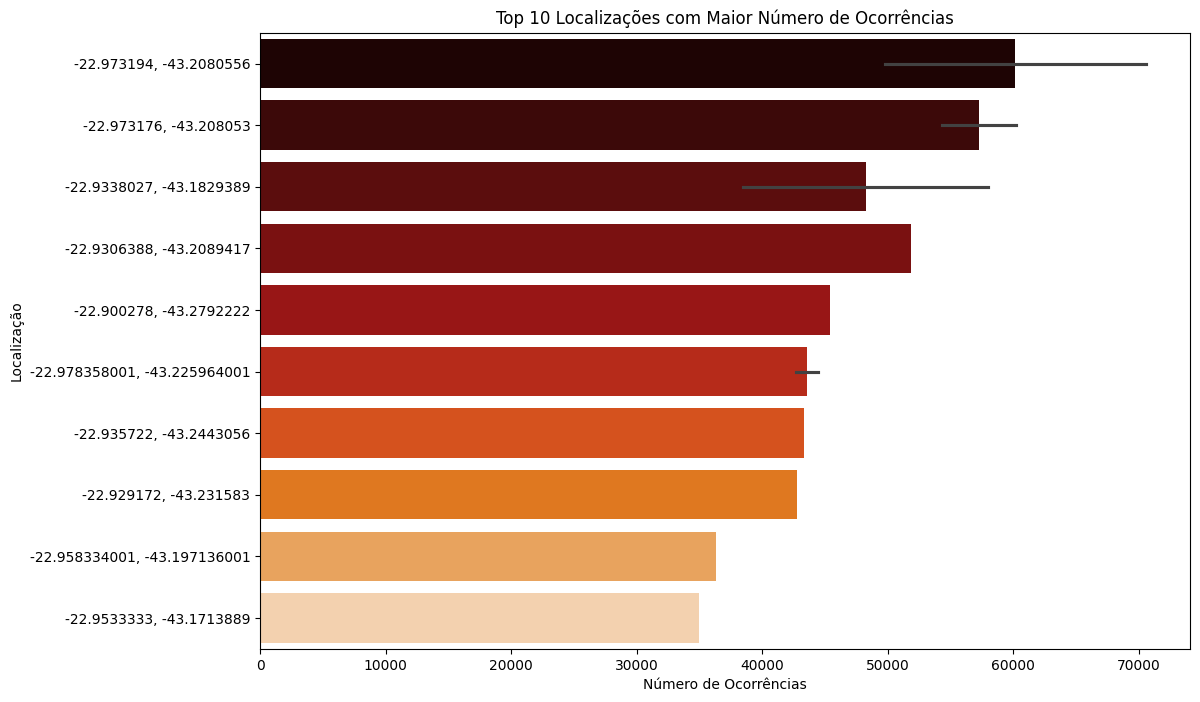

In [120]:
# Agrupar os dados por camera_numero, mantendo a latitude e longitude e contando as ocorrências
camera_counts = result.groupby(['camera_numero', 'camera_latitude', 'camera_longitude']).size().reset_index(name='count')
camera_counts['camera_location'] = camera_counts['camera_latitude'].astype(str)[5:] + ', ' + camera_counts['camera_longitude'].astype(str)[5:]


# Mostrar as câmeras com maior número de ocorrências
top_cameras = camera_counts.nlargest(15, 'count')
print(top_cameras)

# Plotar a distribuição das ocorrências por câmera (Top 15) com coordenadas
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='camera_location', data=top_cameras.head(14), palette='gist_heat')
plt.xlabel('Número de Ocorrências')
plt.ylabel('Localização')
plt.title('Top 10 Localizações com Maior Número de Ocorrências')
plt.savefig('top_cameras.pdf')
plt.show()

In [121]:
from matplotlib import cm

# Função para obter uma cor da paleta viridis
def get_color(index, total, cmap):
    norm_value = index / total
    rgba_color = cmap(norm_value)
    hex_color = "#{:02x}{:02x}{:02x}".format(int(rgba_color[0] * 255), int(rgba_color[1] * 255), int(rgba_color[2] * 255))
    return hex_color

# Inicializar o mapa centrado no Rio de Janeiro
m = folium.Map(location=[-22.9068, -43.1729], zoom_start=12)

# Agrupar os dados por coordenadas e contar o número de ocorrências
coord_groups = top_cameras.head(11).groupby(['camera_latitude', 'camera_longitude']).size().reset_index(name='count')

# Obter a paleta de cores viridis
cmap = cm.get_cmap('gist_heat')

# Adicionar buffers e pontos individuais ao mapa
for index, row in coord_groups.iterrows():
    lat, lon = row['camera_latitude'], row['camera_longitude']
    count = row['count']
    color = get_color(index, len(coord_groups), cmap)

    # Adicionar o buffer
    folium.Circle(
        location=[lat, lon],
        radius=500,  # Buffer de 50 metros
        color=color,
        fill=True,
        fill_color=color,
        popup=f"Count: {count}<br>Latitude: {lat}<br>Longitude: {lon}"
    ).add_to(m)

# Adicionar pontos individuais
for _, row in top_cameras.head(11).iterrows():
    folium.Marker(
        location=[row['camera_latitude'], row['camera_longitude']],
        popup=f"Camera: {row['camera_numero']}<br>Latitude: {row['camera_latitude']}<br>Longitude: {row['camera_longitude']} <br>Count: {row['count']}",
        icon=folium.Icon(color='#800000', icon='info-sign')
    ).add_to(m)


m

<ipython-input-121-97ce63ac817d>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_heat')
<ipython-input-121-97ce63ac817d>:40: UserWarning: color argument of Icon should be one of: {'beige', 'lightred', 'darkpurple', 'gray', 'darkred', 'lightblue', 'orange', 'lightgray', 'darkblue', 'lightgreen', 'pink', 'green', 'black', 'purple', 'white', 'darkgreen', 'cadetblue', 'blue', 'red'}.
  icon=folium.Icon(color='#800000', icon='info-sign')


In [93]:
result

,camera_numero,placa,empresa,tipoveiculo,camera_latitude,camera_longitude,datahora,datahora_captura,velocidade,next_datahora,next_camera_numero,next_latitude,next_longitude,time_diff,distance_km,velocity_kmh,multiple_vehicle_types
0,0e7701876db970,000044cea889d989672e176f7ef96d0bd6,1e2545af9d48c6,e2e0029fc0d3e5,-23.000069,-43.355595,2024-06-12 11:41:14+00:00,2024-06-12 11:42:02+00:00,63,2024-06-12 11:43:02+00:00,f991d6d2db4ed8,-23.000834,-43.334711,108,2.139280,71.309324,False
1,6b12304ce3cf98,00008c1f16d0af418ec9d8c47267bccff8,1e2545af9d48c6,e2e0029fc0d3e5,-22.895700,-43.398268,2024-06-07 00:57:47+00:00,2024-06-07 00:58:01+00:00,47,2024-06-07 21:30:22+00:00,4d41e58362a28a,-22.871944,-43.345556,73955,6.011511,0.292630,True
2,4d41e58362a28a,00008c1f16d0af418ec9d8c47267bccff8,0891967b413fa4,e2e0029fc0d3e5,-22.871944,-43.345556,2024-06-07 21:30:22+00:00,2024-06-07 21:31:03+00:00,35,2024-06-07 22:47:36+00:00,21addaee08ed75,-22.919006,-43.408889,4634,8.335018,6.475197,True
3,21addaee08ed75,00008c1f16d0af418ec9d8c47267bccff8,0891967b413fa4,e2e0029fc0d3e5,-22.919006,-43.408889,2024-06-07 22:47:36+00:00,2024-06-07 22:48:03+00:00,31,2024-06-07 22:58:03+00:00,d438849bbaaed0,-22.919006,-43.408889,627,0.000000,0.000000,True
4,21addaee08ed75,00008c1f16d0af418ec9d8c47267bccff8,0891967b413fa4,e2e0029fc0d3e5,-22.919006,-43.408889,2024-06-07 22:58:03+00:00,2024-06-07 22:59:03+00:00,38,2024-06-07 23:02:11+00:00,21036c75c98397,-22.919545,-43.389907,248,1.944995,28.233799,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10281288,9aa621532a9e9c,ffffdb9b088dc25ddfbae75bcab21d2b96,2ce01a80c7f3d0,7a6376f47ca915,-22.920913,-43.225574,2024-06-11 18:36:36+00:00,2024-06-11 18:41:31+00:00,34,2024-06-12 19:16:31+00:00,6f8b9da0dad83d,-22.969627,-43.217411,88795,5.480871,0.222210,True
10281289,6f8b9da0dad83d,ffffdb9b088dc25ddfbae75bcab21d2b96,1e2545af9d48c6,e2e0029fc0d3e5,-22.969627,-43.217411,2024-06-12 19:16:31+00:00,2024-06-12 19:17:01+00:00,40,NaT,None,NaN,NaN,<NA>,NaN,NaN,True
10281290,e0b15aa49a03a1,ffffe9cbf00d1d60740a8409b05da2a838,1e2545af9d48c6,e2e0029fc0d3e5,-23.000278,-43.407778,2024-06-11 08:23:31+00:00,2024-06-11 08:24:00+00:00,22,2024-06-11 08:27:35+00:00,b4a6d4e1d84621,-23.000069,-43.355595,244,5.341245,78.805253,False
10281291,852e8131d7bc8c,ffffed11fa83e1b9c0bba4a24049232804,2ce01a80c7f3d0,7a6376f47ca915,-22.977775,-43.226473,2024-06-09 15:02:12+00:00,2024-06-09 15:06:11+00:00,26,2024-06-12 02:46:13+00:00,74cfcd8f6dfcdc,-22.890104,-43.524645,215041,32.052921,0.536598,True


In [94]:
result.groupby(['tipoveiculo']).size().reset_index(name='count')


,tipoveiculo,count
0,031cc0037e816d,465113
1,7a6376f47ca915,785076
2,b88652111099ed,309443
3,e2e0029fc0d3e5,8721661


In [95]:
len(result)

10281293